# Using Llama 3.2 Vision for Image Classification

In our [previous tutorial on Llama 3.2 Vision](https://github.com/groq/groq-api-cookbook/blob/main/tutorials/llama-3.2-vision-function-calling.ipynb), we used function calling capabilities to identify the dog breed from an image and use it to call the [API Ninjas Dogs API](https://api-ninjas.com/api/dogs) to extract additional information about the breed. In this tutorial we'll take it a step further to identify more features about the images and create a robust image classification tool for those same dog pictures.

To do so we'll use Llama 3.2 Vision in conjunction with [Groq API's JSON mode](https://console.groq.com/docs/text-chat#json-mode-object-object) to extract specific information from the provided image, such as the breed of dog or its characteristics. By doing so, we'll show how to create a pipeline for image classification and data extraction, converting unstructured images into structured data that can be easily searched, filtered, and analyzed.

### Setup

In [1]:
from groq import Groq
import base64
from IPython.display import Image 
import os
import pandas as pd
import json

To complete this tutorial, you'll need a Groq API key. If you don't already have one, you can easily create a free account on GroqCloud by clicking [here](https://console.groq.com) and generating your API key. Once you have your API key, you'll need to set it as an environment variable called GROQ_API_KEY for the tutorial to work. We'll be working with the llama-3.2-11b-vision-dev model throughout this tutorial.

In [3]:
client = Groq()
model = 'llama-3.2-11b-vision-preview'

### Basic LLaVA usage

For this tutorial, we'll be using the same set of dog images from [Britannica](https://www.britannica.com/animal/dog) that we utilized in the other tutorials. You can access these images in the Groq API cookbook repository, specifically in the [images folder](https://github.com/groq/groq-api-cookbook/tree/main/tutorials/llava-image-processing/images). We'll be encoding a local image to base64 to integrate it with Llama 3.2 Vision. This is one of two methods to use an image with the vision model - the other approach involves providing the actual URL of the image.

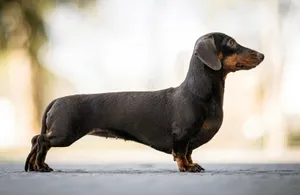

In [4]:
# Load and display the image
image_path = 'images/dachshund.png'
Image(image_path)

To use locally saved images with Llama 3.2 Vision, we'll need to encode them to base64 first:

In [5]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

base64_image = encode_image(image_path)

Analyzing an image with Llama 3.2 Vision using Groq API functions the same as with LLaVA. We'll make a request to the `https://api.groq.com/openai/v1/chat/completions` API endpoint, passing the image and prompt in a JSON structure that includes the image path:

In [6]:
user_prompt = 'Tell me about this image'
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    },
                },
                {"type": "text", "text": user_prompt},
            ],
        }
    ],
    model=model
)

print(chat_completion.choices[0].message.content)

The image shows a side view of a black and tan dachshund. The dog's dark brown coat is emphasized more on the outer body, with light brown splotches running on its throat, chest, and paws. Its tail is plaited/braided and held over the dog's back, and its ears, which are floppy, are tucked over its head.

The dog is standing on a paved surface, indicating that the photo may have been taken in a purpose-built dog training area, dog park, or outside an animal clinic. The background is out of focus and appears to be a white wall made of tiles with a line of darker brown trees. 
Overall, the image is well-composed, making the dog the clear focus of the shot.


However, Llama 3.2 Vision offers more functionality beyond just image recognition. It offers most of the functionality of any other chat model, including tool use and JSON mode (the only thing it can't do is process a system prompt). By leveraging JSON mode, we can utilize Llama 3.2 Vision to identify the breed of the dog in the image and return the result in a structured, easily digestible format. Note that to use JSON mode in the Groq API you must include "JSON" in your system or user prompt, and specify the desired output (see this [cookbook tutorial](https://github.com/groq/groq-api-cookbook/blob/main/tutorials/json-mode-social-determinants-of-health/SDOH-Json-mode.ipynb) for more information):

In [7]:
user_prompt='''
You are an image classification API specializing in dog photos that responds in JSON. What dog breed is shown in this image? 
Return in the following JSON format:

{
  "dog_breed": "string (e.g., 'Golden Retriever', 'German Shepherd', 'Mixed')"
}
'''

def image_classification(base64_image, user_prompt):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    },
                    {"type": "text", "text": user_prompt},
                ],
            }
        ],
        model=model,
        response_format = {"type": "json_object"}
    )

    return json.loads(chat_completion.choices[0].message.content)

image_classification(base64_image, user_prompt)

{'dog_breed': 'Dachshund'}

### Image Classification

With JSON mode enabled, we can leverage Llama 3.2 Vision for robust image classification at scale, making it easy to analyze and categorize large datasets. By iterating through each image in the folder, we can utilize Llama 3.2 Vision to classify them based on various features, such as breed, color, number of dogs, dog activity, and more. This functionality could be particularly valuable for a pet adoption agency, which could use it to streamline the adoption process by uploading an image of a new adoptable pet and instantly making it searchable and filterable by certain features on their website.

First, let's expand our JSON mode prompt to include an array of additional features, and test it on our Dachshund image:

In [9]:
user_prompt = '''
Your job is to extract structured data from an image of dogs and output the structured data in JSON.
The JSON schema should strictly be the following:
  {
    "dog_breed": "string (e.g., 'Golden Retriever', 'German Shepherd', 'Mixed')",
    "dog_color": "string (categorical: 'Black', 'White', 'Brown', 'Golden', 'Multiple')",
    "number_of_dogs": "integer (number of dogs in the image)",
    "puppies_present": "boolean (TRUE if there are puppies in the image)",
    "dog_size": "string (categorical: 'Toy', 'Small', 'Medium', 'Large')",
    "is_pet": "boolean (True if the dog is a pet, False if it might be a wild animal like a wolf or coyote)",
    "dog_activity": "string (categorical: 'Sitting', 'Standing', 'Running', 'Playing', 'Sleeping')",
    "background_environment": "string (categorical: 'Indoors', 'Outdoors', 'Park', 'Beach', 'Forest')",
    "dog_accessories": "string (accessories or items the dog is wearing or carrying, e.g., 'Collar', 'Leash', 'Bandana', 'Toy', 'Stick', 'Ball', 'None')"
  } 
  
Use the information from the following dog photo to construct the proper JSON output.
'''

image_json = image_classification(base64_image, user_prompt)
image_json

{'dog_breed': 'Dachshund',
 'dog_color': 'Black and Tan',
 'number_of_dogs': 1,
 'puppies_present': False,
 'dog_size': 'Small',
 'is_pet': True,
 'dog_activity': 'Standing',
 'background_environment': 'Outdoors',
 'dog_accessories': 'None'}

Looks good! Now, we can apply it to each dog image in our file folder and append the JSON outputs to a list:

In [21]:
image_folder = 'images/'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_json_list = []

for image_file in sorted(image_files):   
    image_path = image_folder + image_file

    # Encode Image
    base64_image = encode_image(image_path)

    # Classify image in JSON mode
    image_json = image_classification(base64_image, user_prompt)

    # Add image file name as a feature
    image_json['image_file'] = image_file

    # Append to image JSON list
    image_json_list.append(image_json)


Finally, we'll convert the results to a pandas dataframe. Now we have a structured table of features from all 18 dog images that can be processed, analyzed, or stored in a database:

In [22]:
dog_image_df = pd.DataFrame(image_json_list)
dog_image_df.head()

,dog_breed,dog_color,number_of_dogs,puppies_present,dog_size,is_pet,dog_activity,background_environment,dog_accessories,image_file
0,Australian Shepherd,Multi,6,True,Small,True,Sitting,Outdoors,None,australian_shepherd_puppies.png
1,Basset Hound,Brown and White,2,True,Medium,True,Sitting,Outdoors,None,basset_hounds.png
2,English Bulldog,White and Brown,1,False,Medium,True,Standing,Outdoors,None,bulldog.png
3,Chihuahua/Mixed,Brown,3,False,Small,True,Standing,Outdoors,None,chihuahuas.png
4,Coyote,Brown/Golden,1,False,Large,False,Running,Outdoors,None,coyote.png


### Conclusion

One of the most valuable things LLMs can do is convert unstructured data to structured data, and as we've seen in this tutorial, you can use Llama 3.2 Vision to do just that with image data. This ability to extract meaningful features from images opens up a wide range of possibilities for applications such as image classification, object detection, and more, and we're excited to see the innovative solutions that developers will create using Llama 3.2 Vision on Groq API!